In [ ]:
import os
import librosa
import numpy as np
import soundfile as sf  # Use soundfile to save audio files

def augment_audio(input_path, output_path, augmentations=3):
    os.makedirs(output_path, exist_ok=True)
    files = os.listdir(input_path)
    for file in files:
        file_path = os.path.join(input_path, file)
        if file.endswith(".wav"):
            audio, sr = librosa.load(file_path, sr=None)

            for i in range(augmentations):
                # Apply random augmentation
                if i % 3 == 0:
                    # Time stretching
                    augmented = librosa.effects.time_stretch(y=audio, rate=np.random.uniform(0.8, 1.2))
                elif i % 3 == 1:
                    # Pitch shifting
                    augmented = librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=np.random.randint(-2, 2))
                elif i % 3 == 2:
                    # Add noise
                    noise = np.random.normal(0, 0.005, len(audio))
                    augmented = audio + noise
                
                # Save the augmented audio
                output_file = os.path.join(output_path, f"{file.split('.')[0]}_aug{i}.wav")
                sf.write(output_file, augmented, sr)  # Use soundfile.write
                print(f"Augmented file saved at: {output_file}")

# Paths
input_crying = "./Dataset/crying"
input_yawning = "./Dataset/yawning"
output_crying = "./Dataset/Augmented/crying"
output_yawning = "./Dataset/Augmented/yawning"

# Run augmentation
augment_audio(input_crying, output_crying)
augment_audio(input_yawning, output_yawning)


In [6]:
import os
import librosa
import numpy as np
import pandas as pd

def extract_features_from_directory(input_dir, output_csv):
    """
    Extracts MFCC features from audio files in a directory and saves to a CSV.

    Parameters:
    - input_dir: Path to the directory containing class subdirectories with .wav files.
    - output_csv: Path to save the resulting CSV file.
    """
    data = []
    labels = []
    for label in os.listdir(input_dir):
        class_dir = os.path.join(input_dir, label)
        if os.path.isdir(class_dir):
            for file in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file)
                if file.endswith(".wav"):
                    try:
                        # Load audio file
                        audio, sr = librosa.load(file_path, sr=None)
                        
                        # Extract MFCC features
                        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)  # 13 MFCC coefficients
                        mfcc_mean = np.mean(mfcc.T, axis=0)  # Mean across time
                        
                        # Add features and label
                        data.append(mfcc_mean)
                        labels.append(label)
                    except Exception as e:
                        print(f"Error processing {file_path}: {e}")

    # Convert to DataFrame
    df = pd.DataFrame(data)
    df['label'] = labels  # Add labels as the last column

    # Save to CSV
    df.to_csv(output_csv, index=False)
    print(f"Feature extraction complete. Data saved to {output_csv}")

# Paths
input_dir = "./Dataset/Augmented"  # Path to directory containing "crying" and "yawning" folders
output_csv = "./audio_features.csv"  # Output CSV file

# Extract features
extract_features_from_directory(input_dir, output_csv)


Feature extraction complete. Data saved to ./audio_features.csv


Classification Report:
              precision    recall  f1-score   support

      crying       1.00      0.87      0.93        15
     yawning       0.94      1.00      0.97        29

    accuracy                           0.95        44
   macro avg       0.97      0.93      0.95        44
weighted avg       0.96      0.95      0.95        44



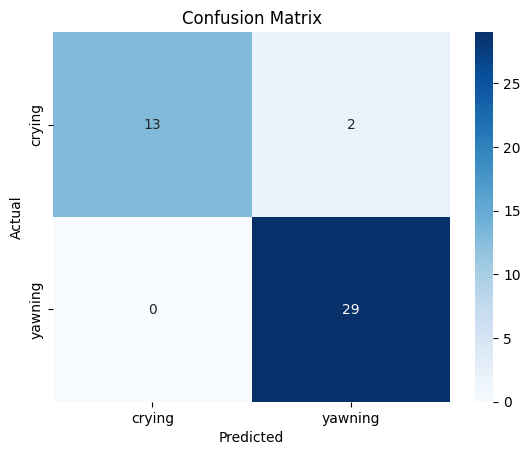

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Reload the dataset since it was cleared from memory
file_path = './audio_features.csv'
audio_features_df = pd.read_csv(file_path)

# Load data
X = audio_features_df.iloc[:, :-1].values  # Feature columns
y = audio_features_df['label'].values      # Labels

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [2]:
import joblib

# Save the model
model_filename = "C:/Users/brain/Desktop/VIGILO_DEPLOY/models/audio_classification_model.pkl"
joblib.dump(model, model_filename)
print(f"Model saved to {model_filename}")

ModuleNotFoundError: No module named 'joblib'

In [14]:
# Load the model
loaded_model = joblib.load(model_filename)
print("Model loaded successfully.")

Model loaded successfully.


In [28]:
import sounddevice as sd
import librosa
import numpy as np
import joblib
import time

# Load the trained model
model_filename = "audio_classification_model.pkl"
loaded_model = joblib.load(model_filename)
print("Model loaded successfully.")

def predict_live_audio(audio, sr, model):
    """
    Predicts the class of a live audio input using the trained model.
    """
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc.T, axis=0).reshape(1, -1)  # Reshape for the model
    
    # Make a prediction
    prediction = model.predict(mfcc_mean)
    return prediction[0]

def continuous_prediction(model, duration=2, sr=22050):
    """
    Continuously records and predicts live audio in short segments.
    """
    print("Starting live prediction. Press Ctrl+C to stop.")
    try:
        while True:
            # Record short audio segment
            audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype='float32')
            sd.wait()  # Wait for the recording to finish
            
            # Flatten the audio and make prediction
            audio = audio.flatten()
            predicted_label = predict_live_audio(audio, sr, model)
            
            # Output the prediction
            print(f"Predicted Label: {predicted_label}")
            
            # Sleep for a short duration before the next recording
            time.sleep(0.5)
    except KeyboardInterrupt:
        print("\nLive prediction stopped.")

# Start live predictions
continuous_prediction(loaded_model, duration=3)

Model loaded successfully.
Starting live prediction. Press Ctrl+C to stop.
Predicted Label: yawning
Predicted Label: yawning
Predicted Label: crying
Predicted Label: crying

Live prediction stopped.


In [1]:
import sounddevice as sd
import librosa
import numpy as np
import joblib
import time

# Load the trained model
model_filename = "C:/Users/brain/Desktop/VIGILO_DEPLOY/models/audio_classification_model.pkl"
loaded_model = joblib.load(model_filename)
print("Model loaded successfully.")

def is_silent(audio, threshold=0.01):
    """
    Checks if the audio is silent based on RMS (Root Mean Square) energy.
    """
    rms = np.sqrt(np.mean(audio**2))
    return rms < threshold

def predict_live_audio(audio, sr, model, silence_threshold=0.01):
    """
    Predicts the class of a live audio input using the trained model, with silence detection.
    """
    # Check for silence
    if is_silent(audio, threshold=silence_threshold):
        return "neutral"  # Return "neutral" if the audio is silent

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc.T, axis=0).reshape(1, -1)  # Reshape for the model

    # Make a prediction
    prediction = model.predict(mfcc_mean)
    return prediction[0]

def continuous_prediction(model, duration=3, sr=22050):
    """
    Continuously records and predicts live audio in short segments.
    """
    print("Starting live prediction. Press Ctrl+C to stop.")
    try:
        while True:
            # Record short audio segment
            audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype='float32')
            sd.wait()  # Wait for the recording to finish
            
            # Flatten the audio and make prediction
            audio = audio.flatten()
            predicted_label = predict_live_audio(audio, sr, model)
            
            # Output the prediction
            print(f"Predicted Label: {predicted_label}")
            
            # Sleep for a short duration before the next recording
            time.sleep(0.5)
    except KeyboardInterrupt:
        print("\nLive prediction stopped.")

# Start live predictions
continuous_prediction(loaded_model, duration=2)


ModuleNotFoundError: No module named 'sounddevice'